# Utilizing time-series similarity as a feature in electrical meter prediction models 

Chun Fu; Clayton Miller<br>
Building and Urban Data Science (BUDS) Lab, Department of Building, National University of Singapore (NUS), Singapore <br>
 
............................................................................................................................................................................................................................

## 0. Abstract
With the growing emphasis on smart grids for more efficient energy management, more and more research is focused on load forecasting models utilizing machine learning techniques. In late 2019, a large dataset which comprises a total of 2,380 meters from nearly 1500 buildings worldwide was used in the ASHRAE - Great Energy Predictor III Machine Learning Competition on the Kaggle platform. This competition provided a good basis for comparison of model methods and also published winning solutions from competition outcomes. However, among models in the competition and past studies, time-series similarity between meters at one site was not included in models. Therefore, this study proposes a two-phase workflow for building load forecasting model: the phase I model was a baseline model, a simple but accurate model trained from one of the competition solutions (site-meter model); the phase II model was a post-processed model utilizing the meter similarity feature to improve phase I prediction result afterward. Without complex skills such as model ensembling or hyperparameters tuning, the proposed method can remarkably reduce RMSLE of phase I model from 1.209 to 1.202, which was validated in the dataset of Kaggle competition.

### Build Run-Time Environment
The following iPython Notebook was built and tested on the following run-time environment:

- Python 3 kernel

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, StratifiedKFold

import gc
import os

............................................................................................................................................................................................................................

## 1. Introduction
Recent decades have seen a burgeoning of machine learning models and the application of that technology to energy forecasting. For example, Platon et al. (2015) employed an Artificial Neural Network to predict daily electricity demand via selected features of weather. Massana et al. (2015) compared the accuracy and computational cost between several modern machine learning models in the prediction of buildings’ electricity demand. In addition to supervised learning mentioned above, Bourdeau et al. (2019) found that researchers also used unsupervised, reinforcement and transfer learning approaches to predict energy consumption in buildings.

However, Miller (2019) mentioned that there is still a lack of a large data set that can be used as a common benchmark for comparing the accuracy of different prediction models with each other. Generally, most previous studies were implemented on a small data set of a single building or community, with a high risk of overfitting for the characteristics of that specific context. With the increasing number of power meters and the growing amount of data from the built environment, the generalizability and scalability of predictive models in the large dataset have received more attention than ever. At the end of 2019, ASHRAE hosted the ASHRAE - Great Energy Predictor III machine learning competition on the Kaggle platform, with the goal of developing the most accurate modeling solution for predicting over 41 million test data points. The data set includes the time-series data of power meter readings from nearly 1500 buildings at 15 locations worldwide. It has laid the foundation for crowd-sourced benchmarks for machine learning of time series data related to the building industry.

Generally, the most common way to build models is to include weather conditions and operation schedules as inputs. Amasyali and El-Gohary (2018) outlined a series of publications that described methods for predicting energy consumption in buildings based on characteristics such as weather, occupancy, and schedule. But in a single site, meters actually do have more or less similarity between each other, and most studies have not pointed out how to integrate such features into the model. This study, therefore, proposes a two-phase method that consists of a basic model for the initial prediction in Phase I and a post-processed model that can further improve the prediction result by adding time-series similarity features in Phase II.


![title](img/intro.png)

## 2. Methods

### 2.1 Open Source Building Energy Benchmarking Data
The 2016 portion of the dataset for "ASHRAE - Great Energy Predictor III" can still be downloaded and analyzed from the Kaggle website, and the technical team is currently preparing to release a larger dataset that includes data for 2016 and 2017 from this competition as part of the Building Data Genome Project (BDG) Version 2.0, the next iteration of BDG 1.0 (Miller and Meggers 2017).

It is an open data set of 2000 buildings from 18 sites that contain the data of the hourly entire building power meter for two years. Each of the buildings has metadata such as area, weather, and primary use type. This data set can be used to compare different statistical learning algorithms and other data science techniques. It can also easily be used as a teaching or learning tool to practice using measured performance data from a large number of non-residential buildings.

##### meter reading
This file includes two years of hourly time-series for each meter. The date range for this training set is Jan 1, 2016 - Dec 31, 2017.
 * `building_id` - Foreign key for the building metadata
 * `meter` - Meter types
 * `timestamp` - When the measurement was taken 
 * `meter_reading` - The target variable: Energy consumption in kWh (or equivalent)
 
##### building meta
This file includes the characteristic data from each building
 * `site_id` - Foreign key for the weather files.
 * `building_id` - Foreign key for the building metadata
 * `primaryspaceusage` - Indicator of the primary category of activities for the building based on EnergyStar property type definitions 
 * `sqft` – Gross floor area of the building
 * `lat` – Latitude of the building site
 * `lng` – Longitude of the building site 
 * `yearbuilt` - Year building was opened
 * `numberoffloors` - Number of floors of the building
 
##### weather data
Weather data from a meteorological station as close as possible to the site
 * `site_id` - Foreign key for the weather files.
 * `temperature` – Degree Fahrenheit
 * `cloudCover` – Portion of the sky covered in clouds
 * `dewPoint` - Degree Fahrenheit
 * `precipIntensity` - Millimeters
 * `pressure` – Millibar/hectopascals
 * `windBearing` – Compass direction (0-360)
 * `windSpeed` – Meters per second

In [2]:
path_data =r'C:\Users\patri\eSIM2020\data'
building_meta=pd.read_pickle(os.path.join(path_data, 'building_meta.pickle'))
df_meter=pd.read_pickle(os.path.join(path_data, 'df_meter.pickle'))
df_weather=pd.read_pickle(os.path.join(path_data, 'df_weather.pickle'))

### 2.2 Phase I: Site-meter load forecasting model
In Phase I, separate models in a LightGBM framework were developed for each site/meter using a subset of the training set based on features of weather and building meta. From the outcome of the competition, up to 90% of the participants chose to use LightGBM as the prediction model, because of its fast training speed and low memory usage with high accuracy. Another important factor that affects accuracy is the strategy of cutting models. In the competition, participants try different model split strategies to improve accuracy, such as meter-split, site-split, or non-split. Among these models, the site-meter split model has the best performance, which is developed separately for different types of meters in a single site (ex. model built for hot water meters in site #1). The prediction result will be verified with retained test data for 2017, and the modeling diagram is as follows:

![title](img/workflow1.png)

In general, the machine learning process involves steps of preparing data, training an algorithm, generating a machine learning model, and making predictions. Although some advanced post-processing techniques, such as model ensembling, were proven necessary in the winning solution in the competition, such a complex process can be computationally intensive and can take hours or even days to complete. In order to obtain a baseline model for benchmarking, a simple machine learning process with only essential steps was implemented in this study. Since there are not many obvious outliers in the dataset, only a few constant trends that are obviously data missing were removed. In the feature engineering section, aside from the features provided by the original dataset, some useful features were further created, e.g. day of week or lag weather features.

The evaluation metric for this research is Root Mean Squared Logarithmic Error (RMSLE), which is consistent with ASHRAE's evaluation method in Kaggle. If the data is highly skewed with extremely large outliers, the error will be significantly amplified when using Root Mean Squared Error (RMSE) evaluation. This metric was therefore selected as it calculated the relative error between prediction and actual values while having robustness to the outliers.

The RMSLE is calculated as the following equation:


\begin{equation*}
\epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }
\end{equation*}

Where:

* `ϵ` is the RMSLE value (score),
* `n` is the total number of observations in the data set,
* `pi` is your prediction of target,
* `ai` is the actual target for `i`,
* `log(x)` is the natural logarithm of `x`.

In [3]:
def add_timestamp_feature(df):
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    
def add_lag_feature(df, window=3):
    cols = ['temperature', 'cloudCover', 'precipIntensity', 'pressure']
    for col in cols:
        df[f'{col}_mean_lag{window}'] = df[col].rolling(window=window, min_periods=0).mean()
        df[f'{col}_median_lag{window}'] = df[col].rolling(window=window, min_periods=0).median()
        
def quantile_meter_reading_df(df, col_meter_reading_log="meter_reading_log1p"):
    # 25th Percentile
    #def q25(x):
    #            return x.quantile(0.25)
    # 50th Percentile
    def q50(x):
                return x.quantile(0.5) 
    # 75th Percentile
    #def q75(x):
    #            return x.quantile(0.75)    
    df_groupby = df.groupby(["meter","timestamp"]).agg(q50_building_meter=(col_meter_reading_log, q50)).reset_index()
    #df_groupby = df.groupby(["meter","timestamp"]).agg(q25_building_meter=(col_meter_reading_log, q25),
    #                                                  q50_building_meter=(col_meter_reading_log, q50),
    #                                                  q75_building_meter=(col_meter_reading_log, q75)).reset_index()

    df_groupby = df_groupby.pivot_table(columns='meter', index='timestamp')
    df_groupby.columns = df_groupby.columns.map('{0[0]}_{0[1]}'.format) 
    df_groupby = df_groupby.reset_index()
    return df_groupby        
        
def fit_lgbm(train, val, seed=666, cat_features=None, num_rounds=200, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {'num_leaves': 31,
              'objective': 'regression',
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
              }

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 50

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

def create_X_y(df_meter_train, meter):
    
    target_df_meter_train = df_meter_train[df_meter_train['meter'] == meter].copy()        
    
    X_train = target_df_meter_train[feature_cols + category_cols]
    y_train = target_df_meter_train['meter_reading_log1p'].values
    
    del target_df_meter_train
    return X_train, y_train

def create_X(df_meter_test, meter):
    
    target_test_df = df_meter_test[df_meter_test['meter'] == meter].copy()        
    X_test = target_test_df[feature_cols + category_cols]
    
    return X_test

def plot_feature_importance(model):
    importance_df = pd.DataFrame(model[1].feature_importance(),
                                 index=feature_cols + category_cols,
                                 columns=['importance']).sort_values('importance')[-10:]
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()      
    
def pred_all(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, (mindex, model) in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total

In [4]:
def preprocess_data(site_id, df_meter=df_meter):
    #Prepare data
    df_meter_site = df_meter[df_meter['building_id'].str.contains(site_id)].copy()
    building_meta_site = building_meta[building_meta['site_id']==site_id]
    df_weather_site = df_weather[df_weather['site_id']==site_id]

    #Add features
    add_timestamp_feature(df_meter_site)
    df_meter_site.loc[:, 'meter_reading_log1p'] = np.log1p(df_meter_site['meter_reading'])

    df_weather_site = df_weather_site.loc[:, ['temperature', 'cloudCover', 'precipIntensity', 'pressure']]
    df_weather_site = df_weather_site.interpolate(limit_direction='both')
    add_lag_feature(df_weather_site, window=3)
    add_lag_feature(df_weather_site, window=72)
    df_weather_site = df_weather_site.reset_index()

    df_meter_site = df_meter_site.merge(building_meta_site, on=['building_id','meter'])
    df_meter_site = df_meter_site.merge(df_weather_site, on='timestamp')

    for str_col in df_meter_site.dtypes[df_meter_site.dtypes=='object'].index:
        le = LabelEncoder()
        df_meter_site[str_col] = le.fit_transform(df_meter_site[str_col])

    df_meter_train = df_meter_site[df_meter_site['timestamp'].dt.year==2016]
    df_meter_test = df_meter_site[df_meter_site['timestamp'].dt.year==2017]   
    
    df_meter_train = df_meter_train.dropna(subset=['meter_reading'])
    
    category_cols = ['building_id', 'dayofweek', 'primaryspaceusage']
    feature_cols = ['hour', 'sqft', 'yearbuilt', 'numberoffloors', 'temperature',             
           'cloudCover', 'precipIntensity', 'pressure', 
           'temperature_mean_lag3', 'temperature_median_lag3', 'temperature_mean_lag72',
           'cloudCover_mean_lag3', 'cloudCover_median_lag3',
           'precipIntensity_mean_lag3', 'precipIntensity_median_lag3',
           'pressure_mean_lag3', 'pressure_median_lag3',
           'temperature_median_lag72', 'cloudCover_mean_lag72',
           'cloudCover_median_lag72', 'precipIntensity_mean_lag72',
           'precipIntensity_median_lag72', 'pressure_mean_lag72',
           'pressure_median_lag72']
    return df_meter_train, df_meter_test, category_cols, feature_cols

In [5]:
#Train Phase I model
def model_train_test(site_id, df_meter_train,
                     category_cols, feature_cols):
    
    #train models
    for meter in df_meter_train['meter'].unique():
        X_train, y_train = create_X_y(df_meter_train, meter=meter)
        y_valid_pred_total = np.zeros(X_train.shape[0])
        gc.collect()
        print('meter', meter, X_train.shape)

        cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
        print('cat_features', cat_features)

        exec('models' +str(meter)+ '=[]')

        df_meter_train_temp = df_meter_train[df_meter_train['meter']==meter].copy()

        mindex = 0
        kf = StratifiedKFold(n_splits=3)
        for train_idx, valid_idx in kf.split(df_meter_train_temp, df_meter_train_temp['building_id']):
            train_data = X_train.iloc[train_idx,:], y_train[train_idx]
            valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

            print (mindex)

            print('train', len(train_idx), 'valid', len(valid_idx))
            model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                                lr=0.05, bf=0.7)
            y_valid_pred_total[valid_idx] = y_pred_valid
            exec('models' +str(meter)+ '.append([mindex, model])')
            mindex = mindex+1
            gc.collect()

        try:
            sns.distplot(y_train)
            sns.distplot(y_valid_pred_total)
            plt.show()
        except:
            pass

        del X_train, y_train
        gc.collect()
    
        exec('plot_feature_importance(models' +str(meter)+'[0])')
        plt.show()
    
    #predict test data
    for meter in df_meter_test['meter'].unique():
        print('meter: ', meter)
        X_test = create_X(df_meter_test, meter=meter)
        gc.collect()

        exec('y_test' +str(meter)+ '= pred_all(X_test, models' +str(meter)+ ')')
        exec('sns.distplot(y_test' +str(meter)+ ')')
        plt.show()

        exec('print(X_test.shape, y_test' +str(meter)+ '.shape)')

        del X_test
        gc.collect()    

    for meter in df_meter_test['meter'].unique():
        exec('df_meter_test.loc[df_meter_test["meter"] == meter,"meter_reading_pred"] = np.expm1(y_test' +str(meter)+ ')')

    df_meter_test.loc[df_meter_test['meter_reading_pred'] < 0, 'meter_reading_pred'] = 0  
    df_meter_test['error_log'] = (np.log1p(df_meter_test['meter_reading']) - np.log1p(df_meter_test['meter_reading_pred']))**2

    return df_meter_test        

In [6]:
%%capture
df_meter_test_merged = pd.DataFrame()

for site_id in building_meta['site_id'].unique():
    df_meter_train, df_meter_test, category_cols, feature_cols = preprocess_data(site_id=site_id)
    
    df_meter_test = model_train_test(site_id=site_id, df_meter_train=df_meter_train,
                                     category_cols=category_cols, feature_cols=feature_cols)
    
    df_meter_test_merged = pd.concat([df_meter_test_merged, df_meter_test[['row_id','meter_reading_pred']]], axis=0)

In [7]:
df_meter = df_meter.merge(df_meter_test_merged, on='row_id', how='left')
df_meter['error_log_phase1'] = (np.log1p(df_meter['meter_reading_pred']) - np.log1p(df_meter['meter_reading']))**2

## 2.3 Phase II: Post-processed model
In Phase II, The proposed model is used for the post-processing of predicted results. The infrastructure of the model is basically the same as the phase I model, but the time-series similarities from other meters were added as new features. However, the number of meters in each group (ex. 100 meters in hot water group in site #1) is sometimes as high as hundreds, and directly adding such a huge amount of features into our models would cause the high risk of overfitting, which sometimes is called “curse of dimensionality”. Therefore, this study used a median filter, which has been widely used for image processing applications to reduce dimensionality and noises, to extract the principal trends in hundreds of time-series data.

![title](img/workflow2.png)

The table below shows a comparison of the machine learning input variables used in Phase I and II:

|                                 | Category   | Features                              | Feature type   |   Amount |
|:--------------------------------|:-----------|:--------------------------------------|:---------------|---------:|
| Features in phase I             | Temporal   | Hour of day                           | categorical    |        1 |
| Features in phase I             | Temporal   | Day of week                           | continuous     |        1 |
| Features in phase I             | Weather    | Outdoor air temp.                     | continuous     |        1 |
| Features in phase I             | Weather    | Pressure                              | continuous     |        1 |
| Features in phase I             | Weather    | Cloud cover                           | continuous     |        1 |
| Features in phase I             | Weather    | Precip. intensity                     | continuous     |        1 |
| Features in phase I             | Meta       | Building id                           | categorical    |        1 |
| Features in phase I             | Meta       | Primary space usage                   | categorical    |        1 |
| Features in phase I             | Meta       | Floor area                            | continuous     |        1 |
| Features in phase I             | Meta       | Number of floors                      | continuous     |        1 |
| Features in phase I             | Meta       | Year built                            | continuous     |        1 |
| Features in phase I             | Lag feat.  | 3 hour lag for weather                | continuous     |        8 |
| Features in phase I             | Lag feat.  | 72 hour lag for weather               | continuous     |        8 |
| Additional features in phase II | Similarity | Medians from each group of site-meter | continuous     |       39 |

In [ ]:
df_meter_quantile = df_meter[['timestamp','building_id','meter','meter_reading','meter_reading_pred']].copy()
df_meter_quantile.loc[~df_meter_quantile['meter_reading_pred'].isna(), 'meter_reading'] = df_meter_quantile.loc[~df_meter_quantile['meter_reading_pred'].isna(), 'meter_reading_pred']
df_meter_quantile = df_meter_quantile.drop('meter_reading_pred', axis=1)
df_meter_quantile = df_meter_quantile.merge(building_meta, on=['building_id', 'meter'])
df_meter_quantile['meter_reading_log1p'] = np.log1p(df_meter_quantile['meter_reading'])
df_meter_quantile['availability'] = ~df_meter_quantile['meter_reading_log1p'].isna()
df_meter_quantile = df_meter_quantile.groupby(["site_id", "meter","timestamp"]).agg(median_building_meter=('meter_reading_log1p', 'median'),
                                                                                    availability_building_meter=('availability', 'mean')).reset_index()
df_meter_quantile.loc[df_meter_quantile['availability_building_meter']< 0.5, 'median_building_meter'] = np.nan
df_meter_quantile = df_meter_quantile.pivot_table(columns=["site_id", 'meter'], values='median_building_meter', index='timestamp')
df_meter_quantile.columns =df_meter_quantile.columns.map('{0[0]}_{0[1]}'.format) 
df_meter_quantile = df_meter_quantile.reset_index()
df_meter_quantile = df_meter_quantile[df_meter_quantile.columns[(~df_meter_quantile.isna()).sum()/len(df_meter_quantile)>0.5]]

In [9]:
def add_similarity_feat(df_meter_train, df_meter_test, feature_cols):
    # Add similarity feature
    df_meter_train = df_meter_train.merge(df_meter_quantile, on=['timestamp'], how='left')
    df_meter_test = df_meter_test.merge(df_meter_quantile, on=['timestamp'], how='left')

    for meter in df_meter_train['meter'].unique():
        name_meter = df_meter[df_meter['row_id']==df_meter_train.loc[df_meter_train['meter']==meter].iloc[0].loc['row_id']]['meter'].values[0]
        df_meter_train.loc[df_meter_train['meter']==meter, df_meter_train.columns[df_meter_train.columns.str.contains('median_building_meter_'+site_id+'_'+name_meter)]]=np.nan
        df_meter_test.loc[df_meter_test['meter']==meter, df_meter_test.columns[df_meter_test.columns.str.contains('median_building_meter_'+site_id+'_'+name_meter)]]=np.nan

    feature_cols = feature_cols + list(df_meter_quantile.drop('timestamp',axis=1).columns)  
    
    return df_meter_train, df_meter_test, feature_cols

In [10]:
%%capture
df_meter_test_postprocessed_merged = pd.DataFrame()

for site_id in building_meta['site_id'].unique():
    
    df_meter_train, df_meter_test, category_cols, feature_cols = preprocess_data(site_id=site_id)

    df_meter_train, df_meter_test, feature_cols = add_similarity_feat(df_meter_train=df_meter_train, df_meter_test=df_meter_test, feature_cols=feature_cols)

    df_meter_test = model_train_test(site_id=site_id, df_meter_train=df_meter_train,
                                     category_cols=category_cols, feature_cols=feature_cols)

    df_meter_test_postprocessed_merged = pd.concat([df_meter_test_postprocessed_merged, 
                                                    df_meter_test[['row_id','meter_reading_pred']]\
                                                    .rename(columns={'meter_reading_pred':'meter_reading_pred_postprocessed'})], axis=0)


In [11]:
df_meter = df_meter.merge(df_meter_test_postprocessed_merged, on='row_id', how='left')
df_meter['error_log_phase2'] = (np.log1p(df_meter['meter_reading_pred_postprocessed']) - np.log1p(df_meter['meter_reading']))**2

## 3. Results and discussion
The RMSLE  of the site-meter baseline model in phase I is 1.209, and in phase 2 the prediction error of the post-processed model can be further reduced to 1.202. Although the percentage reduction in error was only 0.58%, the reduced error was actually significant in a logarithm metric like RMSLE. This two-phase modeling process was also implemented on the Kaggle platform for another validation, the RMSLE  of the baseline model can be improved from 0.961 to 0.952 after making a post-processed model prediction in Phase 2. The corresponding ranking in the public leaderboard can be improved from 242nd to 119th, which is equivalent to enhancement from bronze to silver medal. In both BDG 2.0 dataset and ASHRAE dataset on Kaggle, the proposed two-phase modeling process performed equivalently well.

|                         | BDG2.0 dataset   | ASHRAE dataset on Kaggle       |
|:------------------------|:-----------------|:-------------------------------|
| Phase1 prediction error | RMSLE  = 1.209   | *RMSLE  = 0.961 (Bronze medal) |
| Phase2 prediction error | RMSLE  = 1.202   | *RMSLE  = 0.952 (Silver medal) |
| Δprediction error       | ΔRMSLE  = -0.07  | ΔRMSLE  = -0.09                |

*Validation process on the Kaggle platform could be found as the following links:
https://www.kaggle.com/patrick0302/site-meter-split-sg-no-blend
https://www.kaggle.com/patrick0302/postprocessed-models-leak-median

Looking at the pivot table of prediction errors which were grouped by meter and site, a small portion of the prediction results were even worse than phase I prediction although most post-preprocessed prediction could be improved. The left graph below shows the Squared Logarithm Error (SLE) reduction between phase I and II. It could be observed that the largest increase in errors occurs in the steam meter at the Bull site, chilled water meter at the Eagle site and steam meter at the Moose site. A possible explanation is that there are more noises in both steam and chilled water meter readings, which may lead to inaccurate predictions. In addition, in the right graph with the RLMSE metric, it can be observed that average prediction performance of the chilled water meter at Crow site and steam meter at Moose site deteriorate the most. The more likely explanation might be the numbers of meters in these two sites are small, and such a lack of training data may negatively affect prediction accuracy.

In [12]:
df_meter['improvement'] = df_meter['error_log_phase2']-df_meter['error_log_phase1']

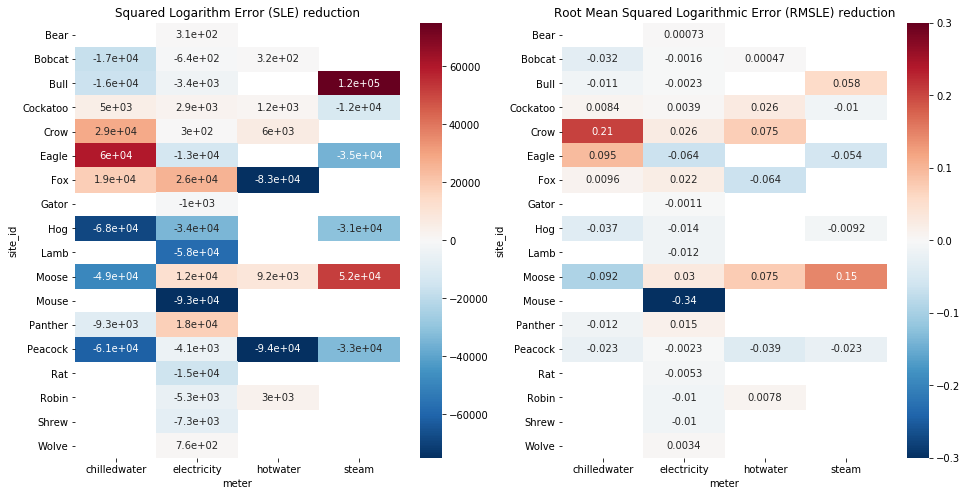

In [13]:
df_plot = df_meter.merge(building_meta, on=['building_id', 'meter']).pivot_table(values='improvement',columns='meter',index='site_id',aggfunc='sum')
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))   
g1 = sns.heatmap(df_plot, annot=True, cmap="RdBu_r",vmin=-75000,vmax=75000, ax=ax1)
ax1.set_title('Squared Logarithm Error (SLE) reduction')

df_meterSite_phase1 = (df_meter.merge(building_meta, on=['building_id', 'meter']).pivot_table(values=['error_log_phase1'],columns='meter',index='site_id'))**0.5
df_meterSite_phase2 = (df_meter.merge(building_meta, on=['building_id', 'meter']).pivot_table(values=['error_log_phase2'],columns='meter',index='site_id'))**0.5
df_plot.loc[:,:] = (df_meterSite_phase2.values-df_meterSite_phase1.values)
g2 = sns.heatmap(df_plot, annot=True, cmap="RdBu_r",vmin=-0.3,vmax=0.3, ax=ax2)
ax2.set_title('Root Mean Squared Logarithmic Error (RMSLE) reduction')
plt.show()

## 3. Conclusion
In this study, we proposed a post-processed model incorporating time series similarity features. Even with median values as a simple statistical measure to extract time-series feature, the prediction error of the baseline model could be effectively reduced after post-processing. In addition, the main advantages of this two-phase method are simplicity of model structure and little demand for computing power, and it does not require advanced machine learning skills such as model ensembling or hyperparameter tuning.

Future research can be conducted in several directions: (1) Although this study had positive results by using the median, more different statistical measures can be tested in the future. (2) In this research, the groups of meters for calculating medians were determined by building metadata. But in the future, clustering techniques in unsupervised machine learning could be used to get more possible grouping methods.


## 4. References
Miller, C., & Meggers, F. (2017). The Building Data Genome Project: An open, public data set from non-residential building electrical meters. Energy Procedia, 122, 439-444.

Amasyali, K., & El-Gohary, N. M. (2018). A review of data-driven building energy consumption prediction studies. Renewable and Sustainable Energy Reviews, 81, 1192-1205.

Miller, C. (2019). More Buildings Make More Generalizable Models—Benchmarking Prediction Methods on Open Electrical Meter Data. Machine Learning and Knowledge Extraction, 1(3), 974-993.

Bourdeau, M., Zhai, X. Q., Nefzaoui, E., Guo, X., & Chatellier, P. (2019). Modelling and forecasting building energy consumption: a review of data-driven techniques. Sustainable Cities and Society.

Massana i Raurich, J., Pous i Sabadí, C., Burgas Nadal, L., Meléndez i Frigola, J., & Colomer Llinàs, J. (2015). Short-term load forecasting in a non-residential building contrasting models and attributes. © Energy and Buildings, 2015, vol. 92, p. 322-330.

Platon, R., Dehkordi, V. R., & Martel, J. (2015). Hourly prediction of a building's electricity consumption using case-based reasoning, artificial neural networks and principal component analysis. Energy and Buildings, 92, 10-18.

Please upload your code and all supporting data files as a compressed .zip file to the eSim 2020 Conftool submission portal: https://www.conftool.com/esim2020
    